In [1]:
pip install Pillow google-genai loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.8 MB/s eta 0:00:00


In [2]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO
import os
import subprocess
import tempfile
from loguru import logger as log
import uuid
import time



In [6]:
import google.colab
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
if not GEMINI_API_KEY:
  google.colab.auth.authenticate_user()


In [19]:
client = genai.Client(api_key=GEMINI_API_KEY)

# subject = "a seed growing into a plant and then blooming into a flower, in a pixel art style"

subject = "an elden ring knight hunched over a laptop to code."
style = "in a 8-bit black and white pixel art style with a few neon highlights."
template = "Create an animation by generating multiple frames, showing"

contents = f"{template} {subject} {style}"

def generate_frames(prompt, max_retries=3):
    """Generate animation frames with retry logic if only one frame is returned."""
    for attempt in range(1, max_retries + 1):
        log.info(f"Attempt {attempt}/{max_retries}: Sending request to Gemini with prompt: {prompt}")

        response = client.models.generate_content(
            model="models/gemini-2.0-flash-exp",
            contents=prompt,
            config=types.GenerateContentConfig(response_modalities=['Text', 'Image'])
        )

        # Count the number of image frames
        frame_count = 0
        if response.candidates:
            for part in response.candidates[0].content.parts:
                if part.inline_data is not None:
                    frame_count += 1

        log.info(f"Received {frame_count} frames in response")

        # If we got multiple frames, return the response
        if frame_count > 1:
            log.info(f"Successfully received {frame_count} frames on attempt {attempt}")
            return response

        # If this was the last attempt, return what we have
        if attempt == max_retries:
            log.warning(f"Failed to get multiple frames after {max_retries} attempts. Proceeding with {frame_count} frames.")
            return response

        # Otherwise, try again with a stronger prompt
        log.warning(f"Only received {frame_count} frame(s). Retrying with enhanced prompt...")
        prompt = f"{prompt} Please create at least 5 distinct frames showing different stages of the animation."
        time.sleep(1)  # Small delay between retries

# Get response with retry logic
response = generate_frames(contents)

# Create a temporary directory to store the frames
with tempfile.TemporaryDirectory() as temp_dir:
    log.info(f"Created temporary directory at {temp_dir}")
    frame_paths = []
    frame_count = 0

    # Process and save each part
    log.info(f"Number of candidates: {len(response.candidates)}")
    if response.candidates:
        log.info(f"Number of parts in first candidate: {len(response.candidates[0].content.parts)}")

        for part_index, part in enumerate(response.candidates[0].content.parts):
            if part.text is not None:
                log.info(f"Text content: {part.text[:100]}...")
                print(part.text)
            elif part.inline_data is not None:
                # Save the image to a temporary file
                frame_path = os.path.join(temp_dir, f"frame_{frame_count:03d}.png")
                image = Image.open(BytesIO(part.inline_data.data))
                image.save(frame_path)
                frame_paths.append(frame_path)
                frame_count += 1
            else:
                log.warning(f"Part {part_index+1} has neither text nor inline_data")
    else:
        log.error("No candidates returned in the response")

    # If we have frames, create a GIF using ffmpeg
    if frame_paths:
        log.info(f"Found {len(frame_paths)} frames to process")
        output_path = os.path.abspath(f"animation_{uuid.uuid4()}.gif")
        log.info(f"Will save animation to {output_path}")

        # List all files in the temp directory to verify
        log.info(f"Files in temp directory: {os.listdir(temp_dir)}")

        # Build ffmpeg command
        ffmpeg_cmd = [
            "ffmpeg",
            "-y",  # Overwrite output file if it exists
            "-framerate", "2",  # 2 frames per second
            "-pattern_type", "glob",
            "-i", f"{temp_dir}/frame_*.png",
            "-vf", "scale=512:-1:flags=lanczos",  # Resize while maintaining aspect ratio
            output_path
        ]

        try:
            cmd_str = ' '.join(ffmpeg_cmd)
            log.info(f"Running ffmpeg command: {cmd_str}")

            # Run ffmpeg and capture output
            result = subprocess.run(
                ffmpeg_cmd,
                check=True,
                capture_output=True,
                text=True
            )

            log.info(f"ffmpeg stdout: {result.stdout}")

            if os.path.exists(output_path):
                log.info(f"Animation successfully saved to {output_path}")
                file_size = os.path.getsize(output_path)
                log.info(f"File size: {file_size} bytes")

                # Open the resulting GIF
                Image.open(output_path).show()
            else:
                log.error(f"Output file {output_path} was not created")
        except subprocess.CalledProcessError as e:
            log.error(f"Failed to create GIF: {e}")
            log.error(f"ffmpeg stdout: {e.stdout}")
            log.error(f"ffmpeg stderr: {e.stderr}")
        except Exception as e:
            log.error(f"Unexpected error: {str(e)}")
    else:
        log.warning("No frames were generated, cannot create animation")

log.info("Script completed")

2025-03-28 08:16:27.529 | INFO     | __main__:generate_frames:14 - Attempt 1/3: Sending request to Gemini with prompt: Create an animation by generating multiple frames, showing an elden ring knight hunched over a laptop to code. in a 8-bit black and white pixel art style with a few neon highlights.
2025-03-28 08:16:42.302 | INFO     | __main__:generate_frames:29 - Received 5 frames in response
2025-03-28 08:16:42.303 | INFO     | __main__:generate_frames:33 - Successfully received 5 frames on attempt 1
2025-03-28 08:16:42.307 | INFO     | __main__:<cell line: 0>:51 - Created temporary directory at /tmp/tmpt99gzw_s
2025-03-28 08:16:42.308 | INFO     | __main__:<cell line: 0>:56 - Number of candidates: 1
2025-03-28 08:16:42.309 | INFO     | __main__:<cell line: 0>:58 - Number of parts in first candidate: 11
2025-03-28 08:16:42.310 | INFO     | __main__:<cell line: 0>:62 - Text content: ## Elden Ring Knight Codes - Animation Frames

Here are several frames depicting an Elden Ring knigh..

## Elden Ring Knight Codes - Animation Frames

Here are several frames depicting an Elden Ring knight hunched over a laptop, coding in 8-bit black and white with neon highlights. Each frame shows a slight change to create a simple animation.

**Frame 1: Initial Posture**




2025-03-28 08:16:42.690 | INFO     | __main__:<cell line: 0>:62 - Text content: 

*   Knight is hunched forward, helmet obscuring face.
*   One gauntleted hand rests on the keyboar...




*   Knight is hunched forward, helmet obscuring face.
*   One gauntleted hand rests on the keyboard, the other hovers slightly above.
*   Laptop screen displays a few lines of neon green code on a neon purple background.
*   A slight neon teal glow emanates from under the helmet visor.

**Frame 2: Typing Action**




2025-03-28 08:16:43.067 | INFO     | __main__:<cell line: 0>:62 - Text content: 

*   The hovering hand is now slightly lower, as if just pressing a key.
*   More neon green code a...




*   The hovering hand is now slightly lower, as if just pressing a key.
*   More neon green code appears on the laptop screen, scrolling slightly.
*   The neon teal glow from the visor flickers slightly brighter.

**Frame 3: Leaning Forward**




2025-03-28 08:16:43.463 | INFO     | __main__:<cell line: 0>:62 - Text content: 

*   The knight leans slightly further towards the laptop screen.
*   The amount of neon green code...




*   The knight leans slightly further towards the laptop screen.
*   The amount of neon green code on the screen increases again, with a subtle change in the pattern.
*   The neon purple background of the screen might have a slight flicker.

**Frame 4: Another Typing Action**




2025-03-28 08:16:43.866 | INFO     | __main__:<cell line: 0>:62 - Text content: 

*   The hands on the keyboard shift slightly, indicating more typing.
*   The code on the screen m...




*   The hands on the keyboard shift slightly, indicating more typing.
*   The code on the screen might show a brief, almost imperceptible animation like a character appearing or a line shifting.
*   The neon teal visor glow dims slightly before brightening again.

**Frame 5: Slight Shift Back**




2025-03-28 08:16:44.272 | INFO     | __main__:<cell line: 0>:62 - Text content: 

*   The knight slightly straightens their posture, as if taking a brief pause.
*   The code on the...
2025-03-28 08:16:44.273 | INFO     | __main__:<cell line: 0>:78 - Found 5 frames to process
2025-03-28 08:16:44.275 | INFO     | __main__:<cell line: 0>:80 - Will save animation to /content/animation_2988b6b7-bba0-4062-a7ed-9d7d5fb39bdb.gif
2025-03-28 08:16:44.276 | INFO     | __main__:<cell line: 0>:83 - Files in temp directory: ['frame_001.png', 'frame_004.png', 'frame_000.png', 'frame_003.png', 'frame_002.png']
2025-03-28 08:16:44.277 | INFO     | __main__:<cell line: 0>:98 - Running ffmpeg command: ffmpeg -y -framerate 2 -pattern_type glob -i /tmp/tmpt99gzw_s/frame_*.png -vf scale=512:-1:flags=lanczos /content/animation_2988b6b7-bba0-4062-a7ed-9d7d5fb39bdb.gif




*   The knight slightly straightens their posture, as if taking a brief pause.
*   The code on the screen remains mostly static, perhaps with a subtle blinking cursor.
*   The neon highlights on the laptop and visor maintain a steady glow.

By cycling through these frames, you'll create a simple animation of the Elden Ring knight coding. You can add more frames with subtle variations in posture, typing, and screen content for a smoother animation. Consider adding a faint neon glow to the edges of the laptop itself in some frames for added visual interest.


2025-03-28 08:16:44.604 | INFO     | __main__:<cell line: 0>:108 - ffmpeg stdout: 
2025-03-28 08:16:44.605 | INFO     | __main__:<cell line: 0>:111 - Animation successfully saved to /content/animation_2988b6b7-bba0-4062-a7ed-9d7d5fb39bdb.gif
2025-03-28 08:16:44.607 | INFO     | __main__:<cell line: 0>:113 - File size: 212272 bytes
2025-03-28 08:16:44.850 | INFO     | __main__:<cell line: 0>:128 - Script completed


'\n    <div>\n        \n    </div>\n    '
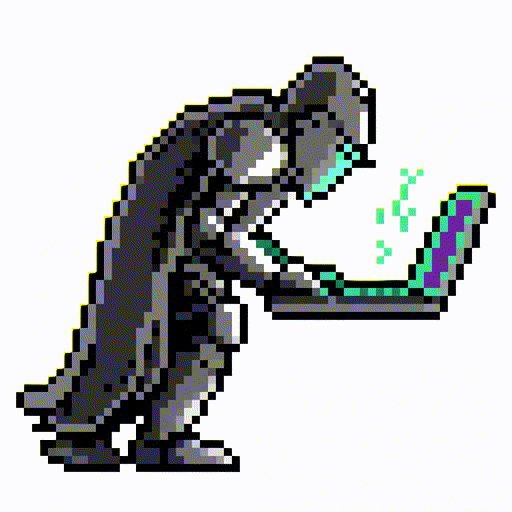

In [20]:
import base64

def gif_to_js_component(gif_path):

    with open(gif_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()

    js_component = f"""
    <div>
        <img src="data:image/gif;base64,{encoded_string}" alt="GIF Image" />
    </div>
    """

    return js_component


gif_file_path = "animation_2988b6b7-bba0-4062-a7ed-9d7d5fb39bdb.gif"
js_code = gif_to_js_component(gif_file_path)
js_code
